In [2]:
import seaborn as sns
from matplotlib.pylab import plt
import pandas as pd
import scipy.stats as stats
import numpy as np
from sklearn import preprocessing
from IPython.core import display

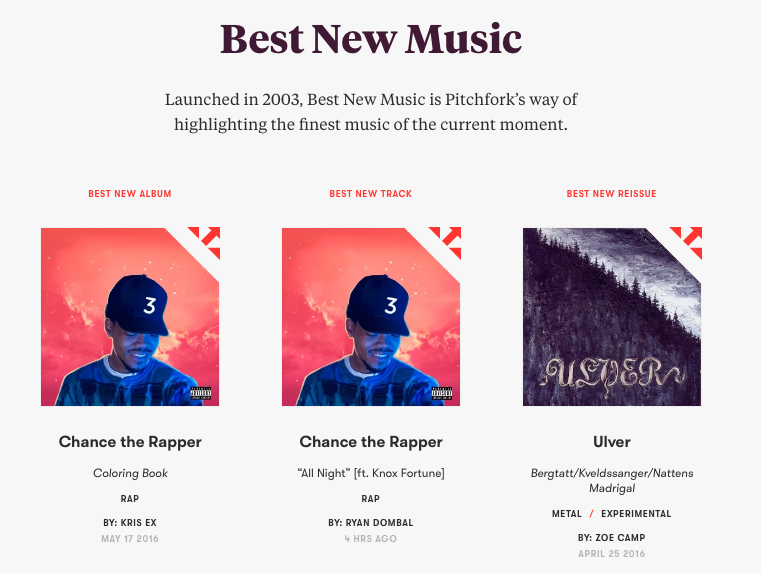

In [3]:
display.Image(filename='savedcharts/bestnewmusic.png')


# Pitchfork Analysis

Since I was a teenager I have paid attention to pitchfork.com. The website acts as a gatekeeper and tastemaker, selecting the newest and greatest underground bands to expose to the masses. I've used it frequently as a quick curation tool to find new music. However, as a regaular reader Pitchfork has frequently come across as pretentious and seemingly random in it's choices for music designated as "Best New Music". Using machine learning I hope to find the features that most designate these choices.

* Using Selenium and beautifulsoup I built a webscraper that went back and grabbed all reviews since 2000.
* With scikit-learn, Keras, nltk we can experiment with some techniques to build a predictive model
* First let's do some exploratory data analysis and charting using matplotlib and seaborn

In [3]:
pfdata = pd.read_excel("dataset/pitchforkdataset.xlsx")

In [4]:
print pfdata.shape
print pfdata.columns

(17252, 8)
Index([u'BestNewMusic', u'album', u'artist', u'author', u'date', u'fullReview',
       u'genre', u'reviewScore'],
      dtype='object')


* We have 17.2k reviews and 9 total columns derived from the webscraper. 
* With this sample size, a neural network may not significantly out perform traditional classification techniques such as logistic regression, SVM or random forests. 

In [5]:
pfdata.head(5)

BestNewMusic                   album           artist  \
0  Not Best New Music  Remixed and Reimagined      Nina Simone   
1  Not Best New Music                 100 Lbs  Matthew Herbert   
2  Not Best New Music      Ten Years of Tears       Arab Strap   
3  Not Best New Music              Chokes! EP         Silkworm   
4  Not Best New Music                 Ecdysis      Miho Hatori   

            author             date  \
0  Mark Richardson  Fri Jan 12 2007   
1   Andy Battaglia  Thu Jan 11 2007   
2      Joe Tangari  Thu Jan 11 2007   
3      Jason Crock  Thu Jan 11 2007   
4    Stuart Berman  Thu Jan 11 2007   

                                          fullReview       genre  reviewScore  
0  The legendary singer and songwriter has her al...        Jazz          3.5  
1  Matthew Herbert's 1996 collection of early dan...        Jazz          8.1  
2  Career-capping compilation from the now-defunc...        Rock          8.2  
3  Originally intended as part of a full-length b...        Rock          7.9  
4  After collaborating with Gorillaz and Beck gui...  Electronic          7.1

(0.9262210130691528, 0.0)

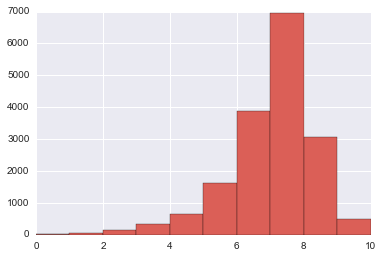

In [12]:
%matplotlib inline
sns.set_palette(sns.color_palette("hls",10))
#pretty colors
pfdata.reviewScore.hist()
#run a KS test to check if data is normal 
stats.shapiro(pfdata.reviewScore)

In [61]:
pfdata.reviewScore.describe()

count    17252.000000
mean         6.998076
std          1.296631
min          0.000000
25%          6.400000
50%          7.200000
75%          7.800000
max         10.000000
Name: reviewScore, dtype: float64

## Review Score
* Looking at the review scores, the average is right around 7. 
* The standard deviation is 1.3.
* The reviews are not from a normal distribution, and will likely need to be transformed if we were to try to create a regression model to predict review scores.

In [62]:
mask = pfdata["BestNewMusic"]=="Best new music"
bnmusic = pfdata[mask==True]
Notbnmusic = pfdata[mask==False]

In [63]:
bnmusic.reviewScore.describe()

count    595.000000
mean       8.611765
std        0.318132
min        7.900000
25%        8.400000
50%        8.500000
75%        8.800000
max       10.000000
Name: reviewScore, dtype: float64

In [64]:
Notbnmusic.reviewScore.describe()

count    16657.000000
mean         6.940433
std          1.281155
min          0.000000
25%          6.400000
50%          7.200000
75%          7.800000
max         10.000000
Name: reviewScore, dtype: float64

* The average Best New Music review scores around an 8.6, over 1 standard deviation from the mean. 
* There are only 595 best new albums since 2003, or around 50 a year not counting 2016. 
* Since there are no labels for albums until 2003, 2000-2002 can be used as a test set for potential new best music

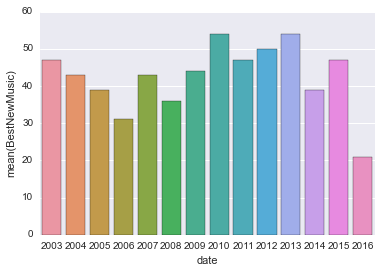

In [66]:
bnmusic.loc[:,"date"] = pd.to_datetime(bnmusic.loc[:,"date"]) 
bnmusicYear = bnmusic.groupby(bnmusic["date"].dt.year).count()
sns.barplot(x= bnmusicYear.index, y=bnmusicYear["BestNewMusic"])

## Genre Exploration 
* Let's look at the genre composition

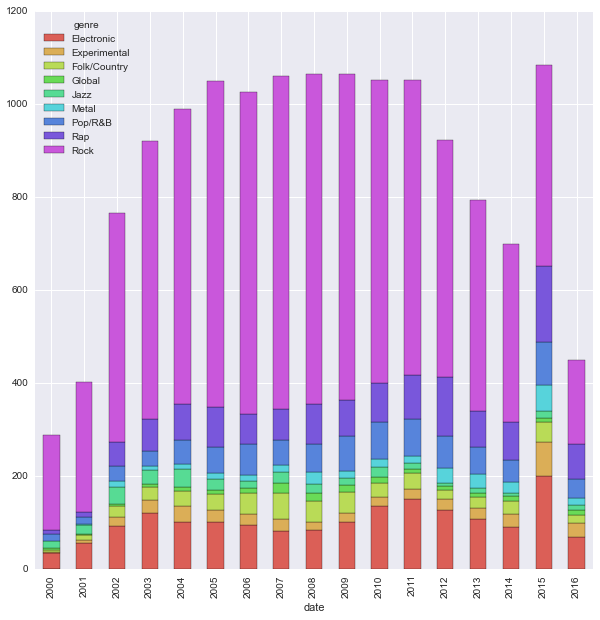

In [43]:
#create datetime object for dates
pfdata.loc[:,"date"] = pd.to_datetime(pfdata.loc[:,"date"]) 
#create grouped dataframe by year and genre
GenreDf = pfdata.groupby([pfdata["date"].dt.year, pfdata["genre"]]).count()
stackedGenre = GenreDf.unstack()["album"].plot.bar(stacked=True, figsize=(10, 10))

* The rock genre makes up most reviews
* Followed by Rap and Electronica 

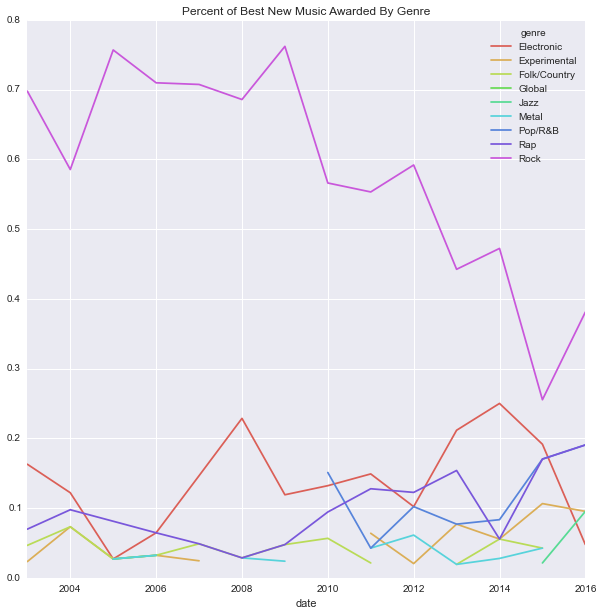

In [14]:
BNMGenre = bnmusic.groupby([bnmusic["date"].dt.year, bnmusic["genre"]])["album"].count().unstack()
#write a small function to convert totals into percents
def percentToTotal(df):
    for l in df.index:
        df.ix[l] = df.ix[l].values / df.ix[l].sum()
    return df
BNMbyGenre = percentToTotal(BNMGenre).plot(kind="line",figsize=(10,10), title="Percent of Best New Music Awarded By Genre")
BNMbyGenre.figure.savefig("bestnewmusicovertime.png")

* Rock has become a much smaller percent of the best new music awarded over time
* Electronica has had three peaks followed by drop offs
* Pop/R&B and Rap have steadily gained over time
* Examining the table below, it's clear that Rock has become a less important genre in terms of number of reviews and number of best new music labels awarded. 
* Since 2010, the Rock genre has typically underperformed it's share of reviews compared to the over performance in years before.

In [15]:
np.round(percentToTotal(GenreDf["album"].unstack())*100,1)

Electronic  Experimental  Folk/Country  Global  Jazz  Metal  Pop/R&B  \
date                                                                         
2000        11.8           1.0           1.4     1.4   5.2    NaN      5.2   
2001        13.9           1.5           3.0     0.5   4.5    0.5      4.0   
2002        12.0           2.7           3.0     0.4   4.8    1.7      4.3   
2003        13.1           3.0           2.9     0.7   3.4    1.0      3.4   
2004        10.3           3.3           3.3     0.8   3.9    1.0      5.3   
2005         9.7           2.4           3.2     1.0   2.1    1.3      5.2   
2006         9.2           2.4           4.3     1.1   1.6    1.3      6.4   
2007         7.7           2.4           5.4     2.1   2.1    1.4      5.2   
2008         7.9           1.7           4.2     1.5   2.0    2.3      5.6   
2009         9.6           1.8           4.2     1.4   1.3    1.4      7.1   
2010        12.9           1.7           3.0     1.2   2.0    1.5      7.6   
2011        14.3           2.1           3.2     1.0   1.1    1.5      7.4   
2012        13.8           2.6           2.2     0.8   0.9    3.5      7.5   
2013        13.5           3.0           3.0     1.0   1.5    3.8      7.2   
2014        12.9           4.0           4.2     1.4   1.0    3.3      6.9   
2015        18.5           6.8           3.9     0.8   1.3    5.3      8.6   
2016        15.3           6.9           3.6     2.2   2.4    3.6      9.1   

       Rap  Rock  
date              
2000   2.8  71.2  
2001   2.7  69.4  
2002   6.8  64.2  
2003   7.5  65.0  
2004   8.0  64.0  
2005   8.3  66.8  
2006   6.3  67.4  
2007   6.2  67.5  
2008   8.2  66.7  
2009   7.2  65.9  
2010   8.1  61.9  
2011   9.0  60.4  
2012  13.5  55.4  
2013   9.7  57.3  
2014  11.7  54.6  
2015  15.0  39.9  
2016  16.7  40.2

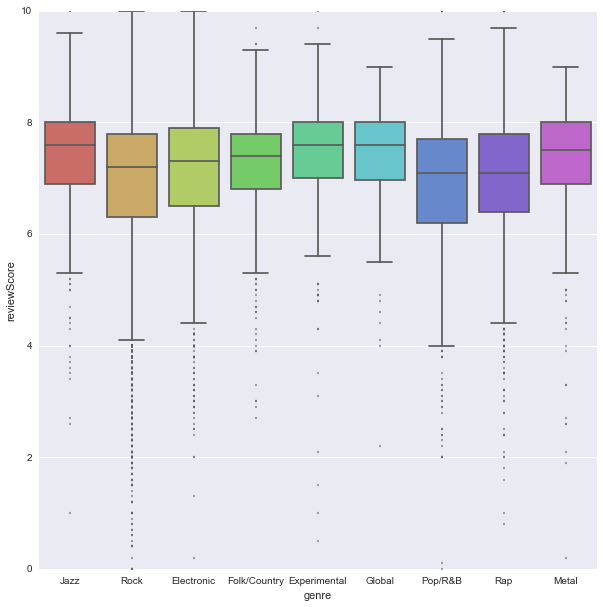

In [68]:
plt.figure(figsize=(10, 10))
boxplot = sns.boxplot(x="genre", y="reviewScore", data=pfdata,fliersize=2)
mask2 = pfdata["BestNewMusic"] == "Best new reissue" #remove reissued music
averageScores = pfdata[mask==False].groupby("genre")['reviewScore'].mean()

* Plotting boxplots for the Genres reveal that there is a bit of bias at the extremes of review distribution
* Electronic and Rock music are the only genres where contemporary music receives a perfect score at the extremes of the distribution 
* Other genres have had outliers with perfect scores, but it is even less likely to occur
* Music that belongs to folk, experiemntal, and global genres, are reviewed less often tend to have a narrower distribution. However, they tend to score higher overall.

In [69]:
averageScores

genre
Electronic      7.009244
Experimental    7.373750
Folk/Country    7.144600
Global          7.343827
Jazz            7.308571
Metal           7.164726
Pop/R&B         6.779167
Rap             6.865116
Rock            6.876849
Name: reviewScore, dtype: float64

## Looking At the Artists and Albums

* Let's do some basic feature engineering
* I created functions to both aggregate the number of albums per artist as well as the chronology of release 

In [7]:
reissueMask = pfdata["BestNewMusic"] != "Best new reissue"

def MoreThanOneReview(df,artist):
        dfmask = df["artist"]==artist
        if artist == "Various Artists":
            return 1
        if df[dfmask==True].shape[0] > 1:
            return df[dfmask==True].shape[0]
        else:
            return 1
        
def chronAlbum(df,artists):
		d = {}
		for artist in artists:
			dfmask = df["artist"]==artist
			if artist == "Various Artists":
				albumOrder = dict(zip(pfdata[dfmask==True].album,np.ones(pfdata[dfmask==True].album.shape[0])))
				d[artist] = albumOrder
			else:
				albumOrder = dict(zip(df[dfmask==True]['album'],range(1,df[dfmask==True].sort_values(by="date").shape[0]+1)))
				d[artist] = albumOrder
		return d

def artistHelper(album,df,albumdict):
    albumMask = df["album"] == album
    k = df[albumMask==True].artist.values
    if len(k) > 0:   
        return albumdict[k[0]][album]
    else:
        return 1

In [8]:
albumDict = chronAlbum(pfdata, pfdata.artist.unique())    
pfdata.drop(6538,inplace=True)
pfdata["NumAlbums"] = pfdata["artist"].apply(lambda x: MoreThanOneReview(pfdata,x))
pfdata["AlbumChron"] = pfdata["album"].apply(lambda x: artistHelper(x,pfdata, albumDict))


In [52]:
pfdata.NumAlbums.hist(by=pfdata["BestNewMusic"],figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1117c89d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11158fb50>]], dtype=object)

* Artists that have scored best new music tend to have multiple albums 
* This is not surprising but could make artist an important feauture

In [53]:
numAlbumsLimit = pfdata["NumAlbums"] <= 5
pfdata[(numAlbumsLimit==True)][["NumAlbums","reviewScore"]].astype(float).groupby("NumAlbums").mean()

reviewScore
NumAlbums             
1             6.876379
2             6.911967
3             7.036993
4             6.997906
5             7.140738

In [55]:
pfdata[(numAlbumsLimit==True)][["AlbumChron","NumAlbums","reviewScore"]].corr()

AlbumChron  NumAlbums  reviewScore
AlbumChron     1.000000   0.666213     0.056950
NumAlbums      0.666213   1.000000     0.064168
reviewScore    0.056950   0.064168     1.000000

* There is not much of a correlation between artists that have multiple albums and higher scores
* Artists that have scored a best new music tend to be reviewed more often which is not unsurprising

In [55]:
%load_ext giphy_magic
%giphy Kanye West

In [80]:
top50 = pfdata[(reissueMask==True) & (mask==True)].sort_values(by="reviewScore",ascending=False).head(50)[["artist","album","reviewScore","date"]] 
top50.head(10)

artist                              album  reviewScore  \
12598          Kanye West  My Beautiful Dark Twisted Fantasy         10.0   
2720          Arcade Fire                            Funeral          9.7   
14873   Animal Collective         Merriweather Post Pavilion          9.6   
2925   The Fiery Furnaces                     Blueberry Boat          9.6   
11938            Bon Iver                           Bon Iver          9.5   
10698         Frank Ocean                     Channel Orange          9.5   
1583           Kanye West                  Late Registration          9.5   
3733            The Wrens                    The Meadowlands          9.5   
10368      Kendrick Lamar             good kid, m.A.A.d city          9.5   
9641           Kanye West                             Yeezus          9.5   

            date  
12598 2010-11-22  
2720  2004-09-12  
14873 2009-01-05  
2925  2004-07-13  
11938 2011-06-20  
10698 2012-07-12  
1583  2005-08-28  
3733  2003-09-29  
10368 2012-10-23  
9641  2013-06-18

### YEEZUS JUST ROSE AGAIN

* Kanye dominates the top 10, 3 of the top 10 best rated albums come from the Chicago based Rapper. 
* The Arcade Fire won a grammy & Kendrick Lamar is a household names but there are some surprises in this list.
* Who has been listening to the Fiery Furnaces lately?

In [87]:
bottom50 = pfdata[(reissueMask==True) & (pfdata.artist != "Various Artists") & (pfdata.date.dt.year > 2002)].sort_values(by="reviewScore",ascending=True).head(50)[["artist","album","reviewScore","date"]] 
bottom50.head(10)

artist                      album  reviewScore  \
2664                Travis Morrison                  Travistan          0.0   
4013                      Liz Phair                  Liz Phair          0.0   
306                             Jet                   Shine On          0.0   
2026                 Robert Pollard  Relaxation of the Asshole          0.0   
3533                           Shat        The Cunt Chronicles          0.2   
15240  Dan Le Sac vs. Scroobius Pip                     Angles          0.2   
1971                         Weezer               Make Believe          0.4   
14869   Black Rebel Motorcycle Club         The Effects of 333          0.4   
1279          Death From Above 1979     Romance Bloody Romance          0.5   
4048                      Metallica                  St. Anger          0.8   

            date  
2664  2004-09-27  
4013  2003-06-24  
306   2006-10-02  
2026  2005-04-20  
3533  2003-12-02  
15240 2008-08-28  
1971  2005-05-08  
14869 2009-01-06  
1279  2005-11-22  
4048  2003-06-15

* I filtered here for reissues, compilation artists, and starting when Best New Music was awarded (2003). 
* Pitchfork has issued 4 zeros with these filters. Liz Phair and Jet are the only recognizable names for me here

# Sentiment Addition & Readability API
* I am going to use Clarabridge's realtime sentiment engine to score the reviews
* This could be another feature used to help us predict best new music albums

# Readability Scores
* I found a great readability API on mashape
* We have several measures on reading ease, but I will default to the Flesch measure

In [9]:
import json 

callresponses = open('/Users/dheepan.ramanan/Documents/PitchforkAnalysis/dataset/readability.txt').read().split("~")

callDicts= {}
for i in enumerate(callresponses):
	try:
		callDicts[i[0]] = json.loads(i[1])
	except ValueError:
		callDicts[i[0]] = {u'ARI': 0,
		 u'CHARACTERS': 0,
		 u'COLEMAN_LIAU': 0,
		 u'COMPLEXWORDS': 0,
		 u'FLESCH_KINCAID': 0,
		 u'FLESCH_READING': 0,
		 u'GUNNING_FOG': 0,
		 u'SENTENCES': 0,
		 u'SMOG': 0,
		 u'SMOG_INDEX': 0,
		 u'SYLLABLES': 0,
		 u'WORDS': 0,
		 u'etag': u'"to4mFGVXeFl3UYs8Sp68GrRZqEw/QTVqcaa2RbNAyR-d3amVlby6x78"',
		 u'kind': u'readability#resourcesItem'}
readabilityDf = pd.DataFrame.from_dict(callDicts).T
floatCols = readabilityDf.columns[:-3]
readabilityDf = readabilityDf[floatCols].astype(float)
pfdataR = pfdata.join(readabilityDf)
readabilityDf.columns

Index([u'ARI', u'CHARACTERS', u'COLEMAN_LIAU', u'COMPLEXWORDS',
       u'FLESCH_KINCAID', u'FLESCH_READING', u'GUNNING_FOG', u'SENTENCES',
       u'SMOG', u'SMOG_INDEX', u'SYLLABLES', u'WORDS'],
      dtype='object')

In [13]:
pfdataR["FLESCH_READING"].mean()

46.945266419338012

Score| School Level|Notes
---|---|---|
90.0–100.0|5th grade|Very easy to read. Easily understood by an average 11-year-old student.
80.0–90.0|6th grade|Easy to read. Conversational English for consumers.
70.0–80.0|7th grade|Fairly easy to read.
60.0–70.0|8th & 9th grade|Plain English. Easily understood by 13- to 15-year-old students.
50.0–60.0|10th to 12th grade|Fairly difficult to read.
30.0–50.0|college|Difficult to read.
0.0–30.0|college graduate|Very difficult to read. Best understood by university graduates.


* My inital thoughts of Pitchfork being written at a high level were on the mark
* At an average reading level of 47, pitchfork is written at the college level
* According to wikipedia Moby Dick scores a 57 on the Flesch Reading scale, meaning the average pitchfork review is even less accessible

In [14]:
pfdataR.corr()["reviewScore"]

reviewScore       1.000000
ARI               0.068764
CHARACTERS        0.069094
COLEMAN_LIAU      0.081817
COMPLEXWORDS      0.059991
FLESCH_KINCAID    0.067425
FLESCH_READING   -0.075412
GUNNING_FOG       0.066723
SENTENCES        -0.059938
SMOG              0.071732
SMOG_INDEX        0.071728
SYLLABLES         0.060125
WORDS             0.013541
Name: reviewScore, dtype: float64

* Even at a surface level, it seems like higher reading levels are loosely associated with higher scores

In [10]:
sentiments = pd.read_excel("dataset/albumsentiment.xlsx")
pfDataRS = pfdataR.join(sentiments[["Sentiment_Score","Sentence_Count"]].astype(float))


In [29]:
pfDataRS[["reviewScore","Sentiment_Score"]].corr()

reviewScore  Sentiment_Score
reviewScore         1.000000         0.037934
Sentiment_Score     0.037934         1.000000

In [39]:
pfDataRS.groupby("genre").mean()["Sentiment_Score"]

genre
Electronic      0.035363
Experimental    0.040920
Folk/Country    0.168772
Global          0.207866
Jazz            0.044844
Metal           0.034787
Pop/R&B         0.132238
Rap             0.022049
Rock            0.043231
Name: Sentiment_Score, dtype: float64

In [101]:
reissueMask = pfdata["BestNewMusic"] != "Best new reissue"
BNMStart = pfdata.date.dt.year > 2002
genreMap = pd.get_dummies(pfDataRS["genre"])
Ftest = pfDataRS.join(genreMap)
Ftest = Ftest[(reissueMask==True) & (BNMStart==True)].drop(["artist","genre","album","fullReview","author","date"],axis=1).dropna()
Fy = Ftest["BestNewMusic"]
Ftest = Ftest.drop("BestNewMusic",axis=1)

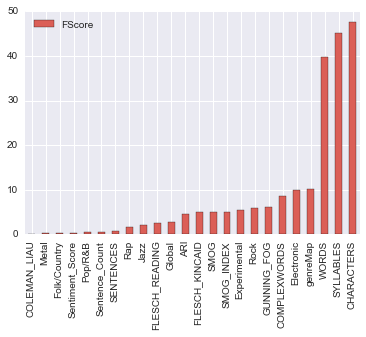

In [158]:
from sklearn.feature_selection import f_classif as fclass
from sklearn.preprocessing import OneHotEncoder

testResults = fclass(Ftest,Fy)

fclass_Pval = pd.DataFrame(testResults[1],index=Ftest.columns,columns=["PValues"])
fclass_Fscore = pd.DataFrame(testResults[0],index=Ftest.columns,columns=["FScore"])
fclass_Fscore.sort_values("FScore").drop("reviewScore",axis=0).plot.bar()

In [163]:
pvalMask = fclass_Pval["PValues"] <= .005
fclass_Pval[pvalMask ==True]

PValues
reviewScore   4.618788e-249
CHARACTERS     5.624075e-12
COMPLEXWORDS   3.398038e-03
SYLLABLES      1.989716e-11
WORDS          3.087665e-10
genreMap       1.455124e-03
Electronic     1.687251e-03

In [11]:
pfDataRS.to_excel("FinalPFDataset.xlsx")

[https://github.com/dheepanr/PitchforkAnalysis/blob/master/Pitchfork%20Feature%20Extraction%20and%20Machine%20Learning%20(RandomForests%20%2B%20TFIDF%20%2B%20WordVectors.ipynb](continued in part 2)